### A8: Generative Models 生成式模型
- 在上个章节中，我们介绍了自动编码器及其变种。`自动编码机(AutoEncoders)`通过学习y=x的恒等变换实现在无监督训练自动提取特征。自动编码机的变种，包括`稀疏自动编码机（SparseAEs）`、`去噪自动编码机（DenoisingAEs）`，通过训练技巧提升了编码的稀疏性和鲁棒性。这一类常常被用于特征提取和降维任务。但是对于生成任务而言，他们并不合适，原因在于原始数据分布在编码器复杂非线性变换的投射下未必是规则的，这不利于我们在生成采样时令解码器得到有意义的结果。
- 变分自动编码机（VAE），借鉴了贝叶斯方法中的变分推断技术，在训练模型学习恒等变换的同时通过引入对编码空间的KL散度进行正则化，使得编码空间在编码过程中保持良好的规范性，有利于在编码空间的采样与插值。
- VAE也可以实现一种有监督的变种：条件变分自动编码机（ConditionalVAE，CVAE），可引入标签数据，实现有标签的生成任务。

VAE的原理：
- 首先，它在AutoEncoder的基础上，假定编码器的结果是一个高斯分布，用于近似后验条件分布P(z|x)，前向传播时对它的均值与方差进行预测。
- VAEs在训练时采用重参数化技巧，计算z=mu + std * eps, （eps从高斯分布上采样得到），使得梯度可以顺利回传至编码器。
- 通过计算重构误差（y与x的误差）和编码空间的KL散度损失，同时对模型约束。

本实验工作内容如下：
- 以`CIFAR-10`和`MNIST`数据集为例，展示条件变分自动编码机（ConditionalVAE，CVAE）的训练和评估
- 提供了美丽的UI界面，用于展示潜在空间的连续性
- 复现了CVAE作为贝叶斯模型，在训练时遇到的“后验坍缩”问题

### 零、安装依赖

In [405]:
!pip install torch torchvision
!pip install numpy
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


### 一、导入模块

In [406]:
import os
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [407]:
class ConditionalConvVAE(nn.Module):
    """
    条件全卷积VAE变分自动编码器
    """
    NAME = 'ConditionalConvVAE'
    
    def __init__(self, potential_dim, channels, num_classes=10):
        super(ConditionalConvVAE, self).__init__()
        self.potential_dim = potential_dim
        self.channels = channels
        
        # 对类别标签进行编码的线性层
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        output_shape = (1024, 4, 4)
        
        output_dim = output_shape[0] * output_shape[1] * output_shape[2]
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(channels + num_classes, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 1024, kernel_size=3, stride=2, padding=1), # output: 1024 x 8 x 8
            nn.ReLU(),
            nn.Flatten(),
        )
        
        
        self.enc_mu = nn.Linear(output_dim, potential_dim)     # 均值
        self.enc_log_var = nn.Linear(output_dim, potential_dim) # 对数方差
        # 解码器
        self.decoder_fc = nn.Linear(potential_dim + num_classes, output_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, output_shape),
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=2, padding=1, output_padding=1),   # output: channel x 28 x 28
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        # 将标签嵌入到与图像相同的维度
        labels = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        labels = labels.expand(labels.size(0), labels.size(1), x.size(2), x.size(3))
        
        # 将标签和图像连接起来
        x = torch.cat((x, labels), dim=1)
        
        # 传入编码器
        x = self.encoder(x)
        mu = self.enc_mu(x)
        log_var = self.enc_log_var(x)
        
        # 重参数化
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu, log_var

    def decode(self, z, labels):
        # 将标签嵌入并与潜在向量连接起来
        labels = self.label_embedding(labels)
        z = torch.cat((z, labels), dim=1)

        # 传入解码器
        x = self.decoder_fc(z)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        z, mu, log_var = self.encode(x, labels)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mu, log_var


# 定义损失函数
def vae_loss(recon_x, x, mu, log_var):
    # 重构损失：通常使用二元交叉熵（BCE）损失
    MSE = nn.functional.mse_loss(recon_x.view(-1, 32*32), x.view(-1, 32*32), reduction='sum')
    # KL 散度损失：用于度量学到的潜在分布与标准正态分布之间的差异
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = MSE + KLD
    return loss, np.array([loss.item(), MSE.item(), KLD.item()])

class DatasetType(Enum):
    cifar10 = 'cifar10'
    mnist = 'mnist'
    fashion_mnist = 'fashion_mnist'
    svhn = 'svhn'

### 三、模型训练

In [408]:
# 查看可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [409]:
# 训练配置
batch_size = 128
epochs = 50
potential_dim = 8
dataset_type = DatasetType.svhn

In [410]:
MODEL_PATH = f'models/cvae_{dataset_type.value}.pth'
HISTORY_PATH = f'history/cvae_{dataset_type.value}_history.npy'
CHANNELS = 1 if dataset_type in [DatasetType.mnist, DatasetType.fashion_mnist] else 3

# 模型和优化器
vae = ConditionalConvVAE(potential_dim=potential_dim, channels=CHANNELS)
vae.to(device)

running_losses = []
if os.path.exists(MODEL_PATH):
    try:
        vae.load_state_dict(torch.load(MODEL_PATH))
        running_losses = list(np.load(HISTORY_PATH)) if os.path.exists(HISTORY_PATH) else []
    except RuntimeError:
        pass

In [411]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

if dataset_type == DatasetType.mnist:
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.cifar10:
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.fashion_mnist:
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.svhn:
    train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
else:
    raise NotImplementedError

optimizer = optim.Adam(vae.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


p_bar = tqdm(range(epochs))
for epoch in p_bar:
    running_loss = np.array([0., 0., 0.])
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data, labels)
        loss, losses = vae_loss(recon_batch, data, mu, log_var)
        loss.backward()
        
        optimizer.step()
        running_loss += 1/(batch_idx + 1) * (losses - running_loss)
        p_bar.set_postfix(progress=f'{(batch_idx+1)/len(train_loader)*100:.2f}%', totalLoss=f'{running_loss[0]:.3f}', MSELoss=f'{running_loss[1]:.3f}', KLDLoss=f'{running_loss[2]:.3f}')
        
    running_losses.append(running_loss)
    np.save(HISTORY_PATH, np.array(running_losses))
    torch.save(vae.state_dict(), MODEL_PATH)

Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 50/50 [09:43<00:00, 11.66s/it, KLDLoss=1183.851, MSELoss=3059.931, progress=100.00%, totalLoss=4243.782]


### 四、绘制损失曲线

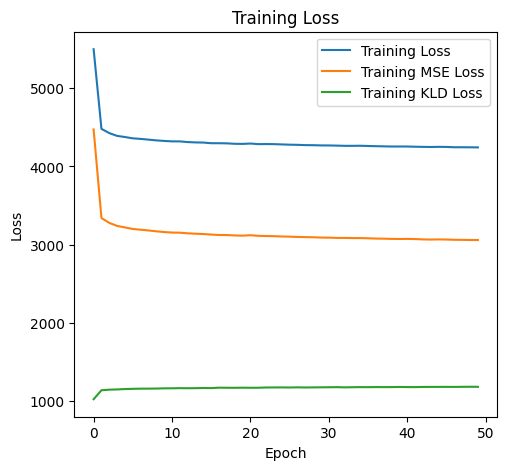

In [412]:
plt.figure(figsize=(12, 5))
total_loss, bce_loss, kld_loss = np.array(running_losses).T
# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(total_loss, label='Training Loss')
plt.plot(bce_loss, label='Training MSE Loss')
plt.plot(kld_loss, label='Training KLD Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### 五、模型推理

In [413]:
def generate(model, labels, device='cuda'):
    with torch.no_grad():
        num_samples = len(labels)
        z = torch.randn(num_samples, model.potential_dim).to(device)
        labels = torch.LongTensor(np.array(labels)).to(device)
        # 通过解码器生成图像
        generated_images = model.decode(z, labels)
    return generated_images

def plot(images):
    plt.figure(figsize=(8, 8))
    channels = images.size(1)
    for i, image in enumerate(images):
        plt.subplot(8, 8, i+1)
        img = image.squeeze().cpu().numpy()
        if channels == 3:
            img = np.transpose(img, (2, 1, 0))
            
        plt.imshow(img, cmap='gray' if channels == 1 else None)
        plt.axis('off')
    plt.show()

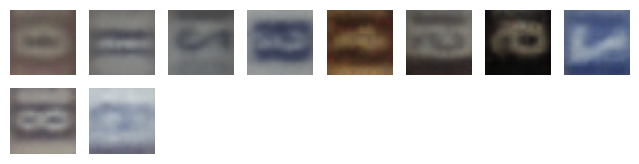

In [414]:
images = generate(vae, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device)
plot(images)

In [415]:
!python cvae_visualizer.py --mnist
# !python cvae_visualizer.py --cifar10
# !python cvae_visualizer.py --fashion_mnist
# !python cvae_visualizer.py --svhn